In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf

## EDA


In [2]:
# Fetch data from Yahoo Finance
df = yf.download(tickers='NVDA', start='2020-01-01')
df_xlk = yf.download(tickers='XLK', start='2020-01-01')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Text(0.5, 1.0, 'NVDA vs XLK Price')

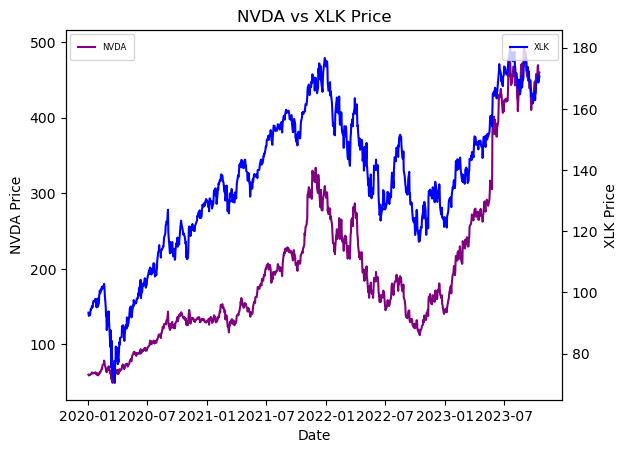

In [3]:
# Finding correlation between NVDA and XLK ETF
fig, ax = plt.subplots()
ax.plot(df['Close'], color='purple', label='NVDA')
ax.set_xlabel('Date')
ax.set_ylabel('NVDA Price')
ax.legend(loc='upper left', borderpad=1, fontsize=6)

ax2 = ax.twinx()
ax2.plot(df_xlk['Close'], color='blue', label='XLK')
ax2.set_ylabel('XLK Price')
ax2.legend(loc='upper right', borderpad=1, fontsize=6)
plt.title('NVDA vs XLK Price')

## Prepare Data

### Log Returns 
$\ln(\frac{Current Price}{Original Price})$

Log returns measure the percentage change in value over time. This allows the time series to be stationary. Log returns will be the target output.

### Index Funds
Index funds are indicators of the general performance of the sector. For this case, the [SPDR Technology Sector Fund (XLK)](https://finance.yahoo.com/quote/XLK?p=XLK) is used as a gauge for the performance of the tech industry as a whole.

In [4]:
# Calculate SMA20 for XLK
df['xlk_SMA20'] = df_xlk['Adj Close'].rolling(20).mean()

# Calculate percentage changes
df['pct_change'] = df['Adj Close'].pct_change()
df['log_return'] = np.log(1 + df['pct_change'])

# Drop Date and Close column
df.dropna(inplace=True)
df.reset_index(inplace=True)
df.drop(['Date', 'Close'], axis=1, inplace=True)

In [5]:
# Normalise data
scaler = MinMaxScaler(feature_range=(0, 1))
df = scaler.fit_transform(df)
df

array([[0.02295221, 0.02021992, 0.03303256, ..., 0.16536163, 0.4334727 ,
        0.48589035],
       [0.02425713, 0.01916477, 0.03041674, ..., 0.16629563, 0.34179245,
        0.39110548],
       [0.01968438, 0.01730993, 0.03081052, ..., 0.16834174, 0.46942607,
        0.52205019],
       ...,
       [0.92393861, 0.94097849, 0.94086542, ..., 0.90636623, 0.43783998,
        0.49031227],
       [0.92798612, 0.93002721, 0.91723859, ..., 0.90641116, 0.35708361,
        0.40718027],
       [0.88602962, 0.90801666, 0.90895796, ..., 0.90704768, 0.45668585,
        0.50929984]])

In [6]:
# Define function to create dataset with timesteps
def create_dataset(dataset, timestep):
    x = []
    y = []
    for i in range(len(dataset) - timestep - 1):
        add_x = dataset[i : i + timestep]
        add_y = dataset[i + timestep]
        x.append(add_x)
        y.append(add_y)
    return np.array(x), np.array(y)

In [7]:
# Split data into training and testing sets
train_size = int(len(df) * 0.8)
train_data, test_data = df[0:train_size], df[train_size:len(df)]

# Apply create_dataset function
X_train, y_train = create_dataset(train_data, 20)
X_test, y_test = create_dataset(test_data, 20)

# Shape should be (samples, timestep, features)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(727, 20, 8) (727, 8) (166, 20, 8) (166, 8)


### Stacked LSTM Implementation
Stacked LSTM allows us to process time series data.

In [8]:
EPOCHS = 10
INPUT_SHAPE = (20, 1)
VALIDATION_SPLIT = 0.1
NUM_VARS = X_train.shape[2]

In [14]:
# Define model
model = keras.Sequential([
    keras.layers.LSTM(64, return_sequences=True, input_shape=INPUT_SHAPE, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(128, return_sequences=True, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(128, return_sequences=True, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(64, return_sequences=True, activation='relu'),    
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(8, activation='linear')
])

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 20, 64)            16896     
                                                                 
 dropout_8 (Dropout)         (None, 20, 64)            0         
                                                                 
 lstm_11 (LSTM)              (None, 20, 128)           98816     
                                                                 
 dropout_9 (Dropout)         (None, 20, 128)           0         
                                                                 
 lstm_12 (LSTM)              (None, 20, 128)           131584    
                                                                 
 dropout_10 (Dropout)        (None, 20, 128)           0         
                                                                 
 lstm_13 (LSTM)              (None, 20, 64)           

In [19]:
# Train model
model.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_test, y_test), batch_size=64)

Epoch 1/10


ValueError: in user code:

    File "/Users/gareth/anaconda3/envs/lstm/lib/python3.11/site-packages/keras/src/engine/training.py", line 1377, in train_function  *
        return step_function(self, iterator)
    File "/Users/gareth/anaconda3/envs/lstm/lib/python3.11/site-packages/keras/src/engine/training.py", line 1360, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/gareth/anaconda3/envs/lstm/lib/python3.11/site-packages/keras/src/engine/training.py", line 1349, in run_step  **
        outputs = model.train_step(data)
    File "/Users/gareth/anaconda3/envs/lstm/lib/python3.11/site-packages/keras/src/engine/training.py", line 1126, in train_step
        y_pred = self(x, training=True)
    File "/Users/gareth/anaconda3/envs/lstm/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/gareth/anaconda3/envs/lstm/lib/python3.11/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential_2' (type Sequential).
    
    Input 0 of layer "lstm_10" is incompatible with the layer: expected shape=(None, None, 1), found shape=(None, 20, 8)
    
    Call arguments received by layer 'sequential_2' (type Sequential):
      • inputs=tf.Tensor(shape=(None, 20, 8), dtype=float32)
      • training=True
      • mask=None
